In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import string
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Data extraction and frequency calculation

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_k2t = pd.read_csv("keyword2tumor_type.csv")
df_train

url  doc_id  label
0   http://elbe-elster-klinikum.de/fachbereiche/ch...       1      1
1   http://klinikum-bayreuth.de/einrichtungen/zent...       3      3
2   http://klinikum-braunschweig.de/info.php/?id_o...       4      1
3   http://klinikum-braunschweig.de/info.php/?id_o...       5      1
4   http://klinikum-braunschweig.de/zuweiser/tumor...       6      3
..                                                ...     ...    ...
95   http://www.unicross.uni-freiburg.de/thema/unifm/     140      1
96  http://www.uniklinik-duesseldorf.de/patienten-...     141      1
97  http://www.vivantes.de/fuer-sie-vor-ort/klinik...     144      2
98  http://www.vivantes.de/fuer-sie-vor-ort/klinik...     145      2
99  http://www.walburga-krankenhaus.de/wk/artikel/...     146      1

[100 rows x 3 columns]

In [3]:
y = df_train['label'].values
train_ids = df_train['doc_id'].values
wordfreq = {}

Initially, I decided to leave only the text from the HTML page and try to get word frequency from train data.

In [4]:
X_train_tokens = []
X_train_sentences = []
for t_id in train_ids:
    with open('htmls/{}.html'.format(t_id), 'rb') as html:
        soup = BeautifulSoup(html, 'html.parser')
    text = ' '
    for hit in soup.find_all(['li', 'p', 'a']):
        text += hit.text
    for ch in string.punctuation:
          text = text.replace(ch, " ")
    tokens = text.split()
    X_train_sentences.append(text)
    X_train_tokens.append(tokens)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [5]:
wordfreq = dict(sorted(wordfreq.items(), key=lambda kv: kv[1], reverse=True))

Let us look at the plots.

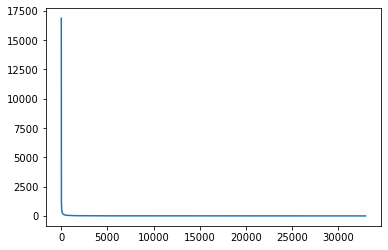

In [6]:
plt.plot(list(wordfreq.values()))

This plot is not so informative, so i decided to look at it after very high frequencies.

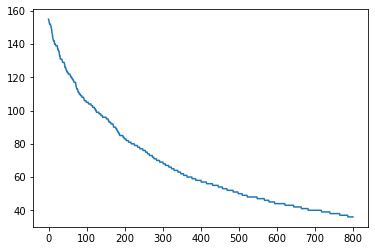

In [7]:
plt.plot(list(wordfreq.values())[200:1000])

We can take in our BOW only the first thousand of the most common words. we will use the BOW because in theory a certain set of words can show the involvement of the text in a particular class. We will use sparse matrices to store BOW, cause of huge number of zeros in sentence vectors.

# The experiments on the dependence of the number of words on the quality of prediction

As an evaluation metric i will use macro f1 score, because it helps to understand the prediction quality for each class independently, but we will look at micro too. To calculate metrics we should create validation data, that will be not included in training of the model.

In [8]:
def model_report(model, x, y):
    y_pred = model.predict(x)
    scores = f1_score(y, y_pred, average='micro'), f1_score(y, y_pred, average='macro')
    return y_pred, scores[0], scores[1]

# def sent2bow(bow, X_train_tokens):
#     X_train = []
#     for i in range (len(X_train_tokens)):
#         vector = np.zeros(bow_len, dtype=int)
#         for j in range(len(X_train_tokens[i])):
#             if X_train_tokens[i][j] in bow:
#                 vector[bow[X_train_tokens[i][j]]]+=1
#         X_train.append(vector)
#     X_train = np.asarray(X_train)
models = [LogisticRegression(solver = 'lbfgs', random_state=1), RandomForestClassifier(random_state=1), XGBClassifier(), MultinomialNB()]
model_names = ["LogisticRegression", "RandomForestClassifier", "XGBClassifier", "MultinomialNB"]
micro_scores = dict.fromkeys(model_names)
macro_scores = dict.fromkeys(model_names)
for key in micro_scores.keys():
    micro_scores[key] = list()
    macro_scores[key] = list()
num_of_words = [i for i in range(1000,10000, 500)]
# for i in range(100, 2000, 100):
for i in range(1000,10000, 500):
    bow_len = i
    bow = dict(zip(list(wordfreq.keys())[:bow_len], [i for i in range(bow_len)]))
    vectorizer = CountVectorizer()
    vectorizer.fit(bow)
    X_train = vectorizer.transform(X_train_sentences)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)
    j=0
    for model, model_name in zip(models, model_names):
        model.fit(X_train, y_train)
        preds, micro, macro = model_report(model, X_val, y_val)
        micro_scores[model_names[j]].append(micro)
        macro_scores[model_names[j]].append(macro)
        print(model_name)
        print(preds)
        j+=1
#         print(model_names[j] + " val macro: ")
#         print("{:.3f}".format(model_report(model, X_val, y_val)[1][1]))

C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\for

LogisticRegression
[3 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2]
RandomForestClassifier
[1 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 1 2 2 2]
XGBClassifier
[2 2 1 2 2 2 1 2 1 2 1 2 2 2 1 2 3 2 2 2]
MultinomialNB
[2 2 2 2 2 2 3 3 2 3 3 2 2 3 2 3 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\s

LogisticRegression
[3 2 2 2 2 2 2 2 1 2 2 1 2 2 1 1 2 2 2 2]
RandomForestClassifier
[1 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 3 2 2 1]
MultinomialNB
[2 2 2 2 2 2 3 3 1 3 3 2 2 3 2 3 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[3 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 1]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 3 2 2 1]
MultinomialNB
[2 2 2 2 2 2 3 3 1 3 3 2 2 3 2 3 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[1 2 2 2 1 2 2 2 1 2 2 2 2 2 1 2 1 2 2 1]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 3 2 2 1]
MultinomialNB
[2 2 2 2 2 2 3 3 1 3 3 2 2 3 2 3 3 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 1]
MultinomialNB
[2 2 2 2 2 2 3 3 1 3 3 2 2 3 2 3 3 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 1 1 2 2 2 2]
RandomForestClassifier
[2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 1 2 2 2]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 1]
MultinomialNB
[2 2 2 2 2 2 3 3 1 3 3 2 2 3 2 3 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[2 2 1 2 2 2 2 2 1 2 2 1 2 2 1 2 1 2 2 1]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 1]
MultinomialNB
[2 2 2 2 2 2 3 3 1 3 3 2 2 3 2 3 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[1 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 1]
MultinomialNB
[2 2 2 2 2 2 3 3 1 3 3 2 2 3 2 3 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[1 2 2 2 2 2 2 2 1 2 2 2 2 2 1 1 2 2 2 1]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 1]
MultinomialNB
[2 2 2 2 2 2 3 3 1 3 3 2 2 3 2 3 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[1 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 1]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 1]
MultinomialNB
[2 2 2 2 2 2 3 3 1 3 3 3 2 3 2 1 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[1 2 1 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 1]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 2 2 1]
MultinomialNB
[2 2 2 2 2 2 3 3 1 3 3 3 2 3 2 1 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 1 1 2 2 2 2]
RandomForestClassifier
[2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 1 2 2 2 1]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 1 2 1]
MultinomialNB
[2 2 1 2 2 2 3 3 1 3 3 3 2 3 2 1 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 1 2 1]
MultinomialNB
[2 2 1 2 2 2 3 3 1 3 3 3 2 3 2 1 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 1 2 1]
MultinomialNB
[2 2 1 2 2 2 3 3 1 3 3 3 2 3 2 1 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[2 2 2 2 2 1 2 2 1 2 1 2 2 2 2 1 1 2 2 1]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 1 2 1]
MultinomialNB
[2 2 1 2 2 2 3 3 1 3 3 3 2 3 2 1 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 1 2 2 1]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 1 2 1]
MultinomialNB
[2 2 1 2 2 2 3 3 1 3 3 3 2 3 2 1 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 1]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 1 2 1]
MultinomialNB
[2 2 1 2 2 2 3 3 1 3 3 3 2 3 2 1 2 2 2 3]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\clas

LogisticRegression
[2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2]
RandomForestClassifier
[2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2]
XGBClassifier
[2 2 1 2 2 2 2 2 1 2 2 2 2 1 1 2 2 1 2 1]
MultinomialNB
[2 2 1 2 2 2 3 3 1 3 3 3 2 3 2 1 2 2 2 3]


In [9]:
y_val

array([1, 2, 2, 2, 1, 3, 2, 1, 2, 1, 1, 3, 2, 2, 2, 3, 2, 1, 2, 1],
      dtype=int64)

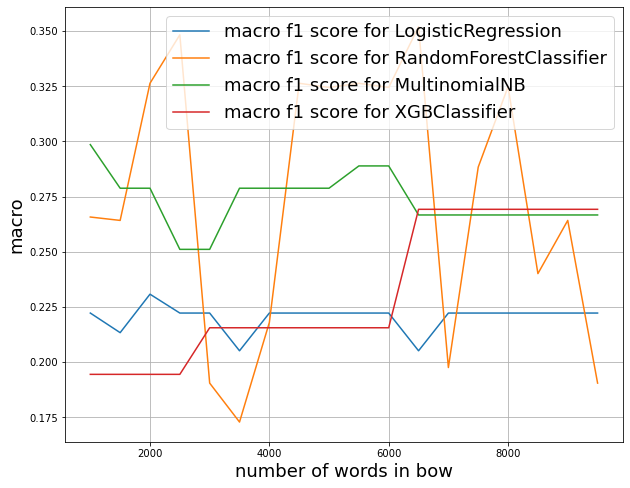

In [10]:
%matplotlib inline
plt.figure(figsize=(10,8))
plt.plot(num_of_words, macro_scores['LogisticRegression'], label="macro f1 score for LogisticRegression")
plt.plot(num_of_words, macro_scores['RandomForestClassifier'], label="macro f1 score for RandomForestClassifier")
plt.plot(num_of_words, macro_scores['MultinomialNB'], label="macro f1 score for MultinomialNB")
plt.plot(num_of_words, macro_scores['XGBClassifier'], label="macro f1 score for XGBClassifier")
plt.legend(fontsize=18)
plt.ylabel("macro", fontsize=18)
plt.xlabel("number of words in bow", fontsize=18)
plt.grid()
plt.show()

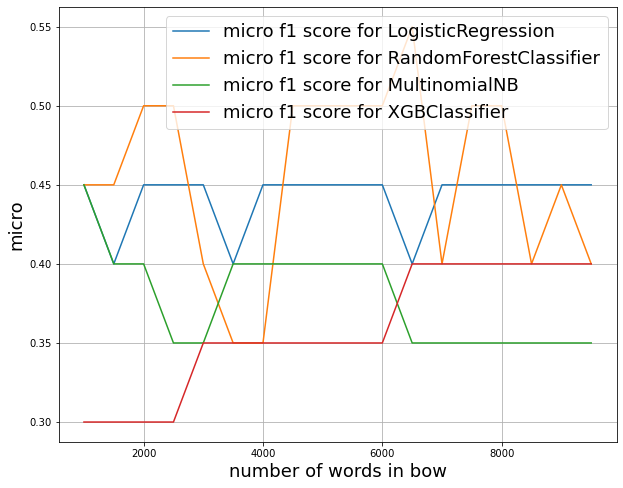

In [11]:
%matplotlib inline
plt.figure(figsize=(10,8))
plt.plot(num_of_words, micro_scores['LogisticRegression'], label="micro f1 score for LogisticRegression")
plt.plot(num_of_words, micro_scores['RandomForestClassifier'], label="micro f1 score for RandomForestClassifier")
plt.plot(num_of_words, micro_scores['MultinomialNB'], label="micro f1 score for MultinomialNB")
plt.plot(num_of_words, micro_scores['XGBClassifier'], label="micro f1 score for XGBClassifier")
plt.legend(fontsize=18)
plt.ylabel("micro", fontsize=18)
plt.xlabel("number of words in bow", fontsize=18)
plt.grid()
plt.show()

# One-VS-Any

From the plots it is impossible to determine the effect of the number of words in BOW on the prediction. Let's try to solve the problem one-VS-any, where the main class will be a high coincidence.

In [12]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(X_train_sentences)

In [13]:
for i in range(len(y)):
    if y[i] == 2:
        y[i] = 1
    if y[i] == 3:
        y[i] = 2

In [14]:
models = [LogisticRegression(solver = 'lbfgs', random_state=1), RandomForestClassifier(random_state=1), XGBClassifier(), MultinomialNB()]
model_names = ["LogisticRegression", "RandomForestClassifier", "XGBClassifier", "MultinomialNB"]
micro_scores = dict.fromkeys(model_names)
macro_scores = dict.fromkeys(model_names)
for key in micro_scores.keys():
    micro_scores[key] = list()
    macro_scores[key] = list()
num_of_words = [i for i in range(1000,10000, 500)]
for i in range(1000,10000, 500):
    bow_len = i
    bow = dict(zip(list(wordfreq.keys())[:bow_len], [i for i in range(bow_len)]))
    vectorizer = CountVectorizer()
    vectorizer.fit(bow)
    X_train = vectorizer.transform(X_train_sentences)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)
    j=0
    for model, model_name in zip(models, model_names):
        model.fit(X_train, y_train)
        preds, micro, macro = model_report(model, X_val, y_val)
        print(model_name)
        print(preds)
        micro_scores[model_names[j]].append(micro)
        macro_scores[model_names[j]].append(macro)
        j+=1
#         print(model_names[j] + " val macro: ")
#         print("{:.3f}".format(model_report(model, X_val, y_val)[1][1]))

C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 1 2 2 1 2 1 1 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 1 2 2 1 2 1 1 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 1 2 2 1 2 1 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 1 2 2 1 2 2 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 1 2 2 1 2 2 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 1 2 2 1 2 2 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 1 2 2 1 2 2 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 1 2 2 1 2 2 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 1 2 2 1 2 2 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 2 2 2 1 2 2 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 2 2 2 1 1 2 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 2 2 2 1 2 2 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 2 2 2 1 2 2 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 2 2 2 1 2 2 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[2 1 1 1 1 2 2 2 1 2 2 2 2 2 1 2 2 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[2 1 1 1 1 2 2 2 1 2 2 2 2 2 1 2 1 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[2 1 1 1 1 2 2 2 1 2 2 2 2 2 1 2 1 2 1 2]


C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\furae\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LogisticRegression
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
RandomForestClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
XGBClassifier
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
MultinomialNB
[1 1 1 1 1 2 2 2 1 2 2 2 2 2 1 1 1 2 1 2]


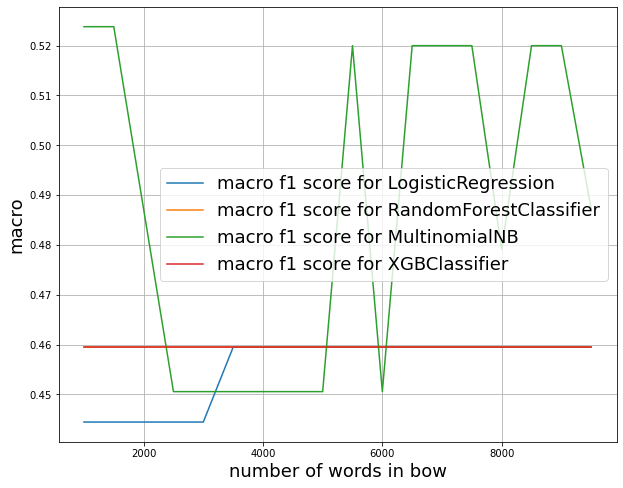

In [15]:
%matplotlib inline
plt.figure(figsize=(10,8))
plt.plot(num_of_words, macro_scores['LogisticRegression'], label="macro f1 score for LogisticRegression")
plt.plot(num_of_words, macro_scores['RandomForestClassifier'], label="macro f1 score for RandomForestClassifier")
plt.plot(num_of_words, macro_scores['MultinomialNB'], label="macro f1 score for MultinomialNB")
plt.plot(num_of_words, macro_scores['XGBClassifier'], label="macro f1 score for XGBClassifier")
plt.legend(fontsize=18)
plt.ylabel("macro", fontsize=18)
plt.xlabel("number of words in bow", fontsize=18)
plt.grid()
plt.show()

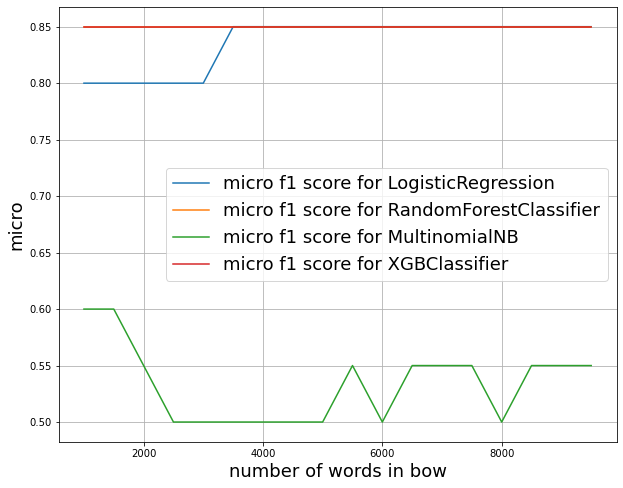

In [16]:
%matplotlib inline
plt.figure(figsize=(10,8))
plt.plot(num_of_words, micro_scores['LogisticRegression'], label="micro f1 score for LogisticRegression")
plt.plot(num_of_words, micro_scores['RandomForestClassifier'], label="micro f1 score for RandomForestClassifier")
plt.plot(num_of_words, micro_scores['MultinomialNB'], label="micro f1 score for MultinomialNB")
plt.plot(num_of_words, micro_scores['XGBClassifier'], label="micro f1 score for XGBClassifier")
plt.legend(fontsize=18)
plt.ylabel("micro", fontsize=18)
plt.xlabel("number of words in bow", fontsize=18)
plt.grid()
plt.show()

If out main target is to find pages with high confidence, then we can use this tactic.

# Test predictions

We will try to predict all 3 classes. From previous plots we can see that the most stable algorithm is a NaiveBayes and 6000 words is a good number for BOW.

In [18]:
X_test_tokens = []
X_test_sentences = []
test_ids = df_test['doc_id'].values
for t_id in test_ids:
    with open('htmls/{}.html'.format(t_id), 'rb') as html:
        soup = BeautifulSoup(html, 'html.parser')
    text = ' '
    for hit in soup.find_all(['li', 'p', 'a']):
        text += hit.text
    for ch in string.punctuation:
          text = text.replace(ch, " ")
    tokens = text.split()
    X_test_sentences.append(text)
    X_test_tokens.append(tokens)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [22]:
df_train = pd.read_csv("train.csv")
y = df_train['label'].values
model = MultinomialNB()
num_of_words = 6000
bow = dict(zip(list(wordfreq.keys())[:num_of_words], [i for i in range(bow_len)]))
vectorizer = CountVectorizer()
vectorizer.fit(bow)
X_test = vectorizer.transform(X_test_sentences)
X_train = vectorizer.transform(X_train_sentences)
y_train = y
model.fit(X_train, y_train)
preds = model.predict(X_test)
#         print(model_names[j] + " val macro: ")
#         print("{:.3f}".format(model_report(model, X_val, y_val)[1][1]))

In [23]:
y

array([1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 2, 3, 1, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2,
       1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 1, 1, 2, 1, 2, 2, 2, 3,
       2, 3, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1], dtype=int64)

In [24]:
df_test['predictions'] = preds
df_test.to_csv("test.csv")

One possible improvement could be a separate review of word frequencies for each of the categories. Manual rules can also help: For example, the presence of the words Fallbesprechung and etz. we can also try to work with sentence embeddings.If we had more data, we could use neural networks with different architectures. For example, LSTM, GRU and BERT.